# Investigation of alternative to baseline-dependent averaging.

The idea is to partition the visibility into inner and outer parts. The density of samples in the inner parts of the uv plane is much greater so we can afford to use coarser gridding but with the same field of view as used for the
further out data. The computation required for the inner, dense region of the Fourier plane is just a complex addition, instead of a complete gridding kernel complex add. This approach should rival two-region baseline-dependent averaging.

In this notebook, we investigate the consequences of imaging in this way.

In [3]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, create_image_from_array, reproject_image
from arl.fourier_transforms.fft_support import extract_mid
from arl.visibility.compress import compress_visibility, decompress_visibility
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW configuration

In [4]:
low = create_named_configuration('LOWBD2')

We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [5]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 8)
frequency = numpy.linspace(0.95e8,1.05e8,7)
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, spectral_mode='channel',
                      reffrequency=1e8, channelwidth=5e7, npol=1) 

create_visibility: Visibility has 654080 rows, total size 2.412 GB
create_visibility: Visibility has 654080 rows, total size 2.412 GB


create_visibility_from_rows: Created view into visibility table
create_visibility_from_rows: Created view into visibility table


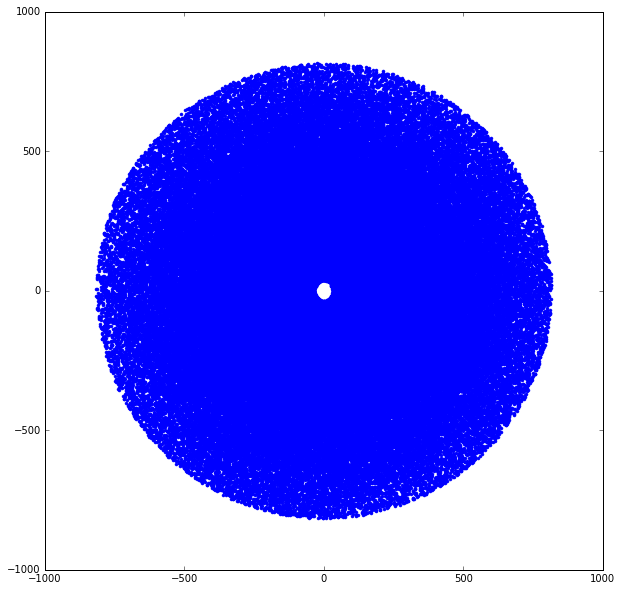

In [6]:
boundary = 0.01
visr = numpy.sqrt(vt.u**2+vt.v**2)
uvmax = numpy.max(visr)
inner_rows = (numpy.abs(visr)  < boundary * uvmax)
vts = create_visibility_from_rows(vt, inner_rows)
plt.clf()
plt.plot(vts.u, vts.v, '.')
plt.show()

Create a model to serve as the image specification

In [7]:
model = create_image_from_visibility(vts, npixel=4096, npol=1, cellsize=0.0005)

create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 1666666.6666666716 Hz
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 1666666.6666666716 Hz
create_wcs_from_visibility: uvmax = 285.577065 wavelengths
create_wcs_from_visibility: uvmax = 285.577065 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.001751 radians, 0.100316 degrees
create_wcs_from_visibility: Critical cellsize = 0.001751 radians, 0.100316 degrees
create_wcs_from_visibility: Cellsize          = 0.000500 radians, 0.028648 degrees
create_wcs_from_visibility: Cellsize          = 0.000500 radians, 0.028648 degrees
image.operations: created image of shape (7, 1, 4096, 4096), size 10.500 (GB)
image.

Compress the visibilities using a grid

get_ftprocessor_params: effective uv cellsize is 0.2 wavelengths
get_ftprocessor_params: effective uv cellsize is 0.2 wavelengths
compress_visibility: Compressed 148245 visibility rows into 929842 rows on a regular grid
compress_visibility: Compressed 148245 visibility rows into 929842 rows on a regular grid


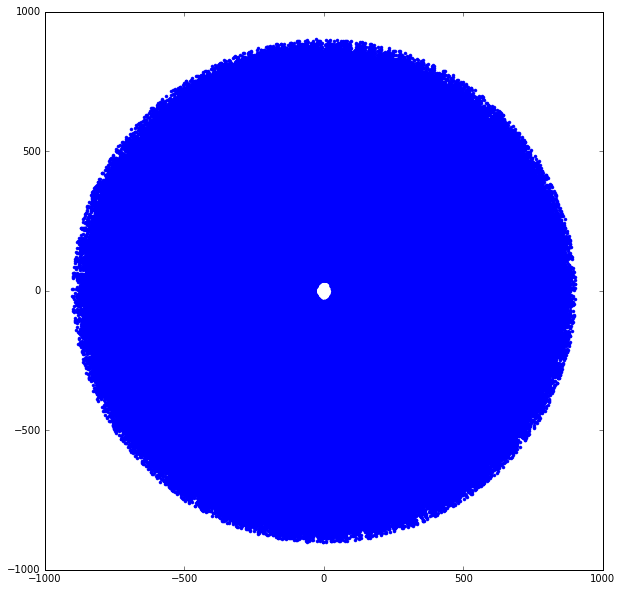

In [8]:
cvt = compress_visibility(vts, model)
plt.clf()
plt.plot(cvt.u, cvt.v, '.')
plt.show()

get_ftprocessor_params: effective uv cellsize is 0.2 wavelengths
get_ftprocessor_params: effective uv cellsize is 0.2 wavelengths
compress_visibility: Decompressing 929842 visibility rows on a regular grid into 148245 rows
compress_visibility: Decompressing 929842 visibility rows on a regular grid into 148245 rows


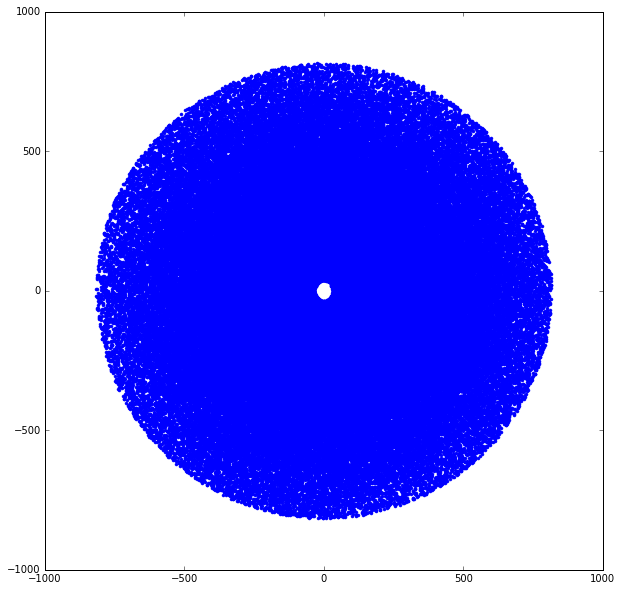

In [9]:
dcvt = decompress_visibility(cvt, vts, model)
plt.clf()
plt.plot(dcvt.u, dcvt.v, '.')
plt.show()